In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import multivariate_normal as mvn
from scipy.stats import multinomial as mlvn
from scipy.stats import bernoulli as brn
%matplotlib inline

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, righmt=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [2]:


data_train = np.load('kmnist-train-imgs.npz', allow_pickle=True)
lst = data_train.files

#for item in lst:
#    print(item)
#    print(data_train[item])


data_test = np.load('kmnist-test-imgs.npz', allow_pickle=True)
lst = data_test.files

#for item in lst:
#    print(item)
#    print(data_test[item])


data_test_label = np.load('kmnist-test-labels.npz', allow_pickle=True)
lst = data_test_label.files

#for item in lst:
#    print(item)
#    print(data_test_label[item])


data_train_labels = np.load('kmnist-train-labels.npz', allow_pickle=True)
lst = data_train_labels.files

#for item in lst:
#    print(item)
#    print(data_train_labels[item])

In [4]:
train_data = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_data = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

In [5]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
test_labels.shape

(60000, 28, 28)
(60000,)
(10000, 28, 28)


(10000,)

In [6]:
print(train_data[:,-1].shape)
X = train_data[:, -1]
X

(60000, 28)


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0]], dtype=uint8)

In [7]:
print(train_labels.shape)
y = train_labels
y

(60000,)


array([8, 7, 0, ..., 0, 4, 9], dtype=uint8)

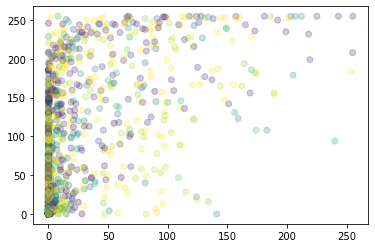

In [8]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y, alpha = 0.25)

In [9]:
class GaussNB():
    def fit(self, X, y, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k,:]
            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":X_k.var(axis=0) + epsilon}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        
        P_hat = np.zeros((N,len(self.K)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
        return P_hat.argmax(axis = 1)

In [10]:
gnb = GaussNB()
gnb.fit(X,y)
y_hat = gnb.predict(X)

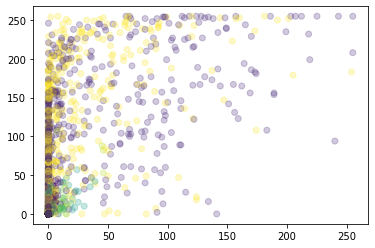

In [52]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y_hat, alpha = 0.25)

In [16]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [17]:
print(f"Accuracy: {accuracy(y, y_hat):0.3f}")

Accuracy: 0.200


In [12]:
class GaussBayes():
    def fit(self, X, y, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k,:]
            N_k, D = X_k.shape
            mu_k=X_k.mean(axis=0)
            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        
        P_hat = np.zeros((N,len(self.K)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
            
        return P_hat.argmax(axis = 1)

In [13]:
GB = GaussBayes()
GB.fit(X,y)
y2_hat = GB.predict(X)

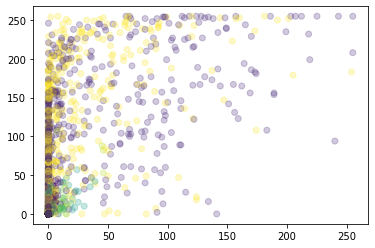

In [14]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y2_hat, alpha = 0.25)

In [18]:
print(f"Accuracy: {accuracy(y, y2_hat):0.3f}")

Accuracy: 0.224


In [19]:
class GenGaussBayes():
    def fit(self, X, y, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y == k,:]
            N_k, D = X_k.shape
            mu_k=X_k.mean(axis=0)
            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X,DistFam):
        N, D = X.shape
        
        P_hat = np.zeros((N,len(self.K)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = DistFam(X, l["mean"], l["cov"]) + np.log(self.priors[k])
            
        return P_hat.argmax(axis = 1)

In [20]:
def DSel(dstring):
    if dstring=="Gauss" or dstring== "Gaussian" or dstring=="gauss" or dstring=="gaussian":return mvn.logpdf
    if dstring=="multi" or dstring== "Multinomial" or dstring=="multinomial" or dstring=="Multi":return mlvn.logpmf   



In [22]:

my_dist=mvn.logpdf
GGB = GenGaussBayes()
GGB.fit(X,y)
y3_hat = GGB.predict(X,DSel("gauss"))

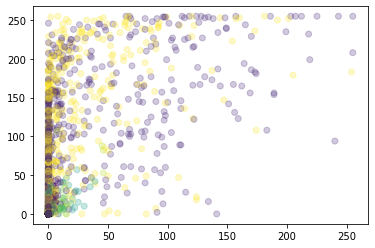

In [23]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c = y3_hat, alpha = 0.25)

In [30]:
class GenMultBayes():
    
    def fit(self, X, y,DisStr, epsilon = 1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        if DisStr=="Gauss":
        
            for k in self.K:
                X_k = X[y == k,:]
                N_k, D = X_k.shape
                mu_k=X_k.mean(axis=0)
                self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
                self.priors[k] = len(X_k)/len(X)
            return
        if DisStr=="Multinomial":
            for k in self.K:
                X_k = X[y == k,:]
                N_k, D = X_k.shape
                mu_k=X_k.mean(axis=0)
                self.likelihoods[k] = {"N":N, "P":sum(N_k/len(X))}
                self.priors[k] = len(X_k)/len(X)
            
        if DisStr=="Bernoulli":
            for k in self.K:
                X_k = X[y == k,:]
                N_k, D = X_k.shape
               
                self.likelihoods[k] = {"P":N_k/len(X)}
                self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X,DistStr):
        N, D = X.shape
        
        if DisStr=="Gauss":
            P_hat = np.zeros((N,len(self.K)))

            for k, l in self.likelihoods.items():
                P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

            return P_hat.argmax(axis = 1)
        
        if DisStr=="Multinomial":
            P_hat = np.zeros((N,len(self.K)))

            for k, l in self.likelihoods.items():
                P_hat[:,k] = mlvn.logpmf(X, l["N"], l["P"]) + np.log(self.priors[k])

            return P_hat.argmax(axis = 1)

        if DisStr=="Bernoulli":
            P_hat = np.zeros((N,len(self.K)))

            for k, l in self.likelihoods.items():
                P_hat[:,k] = bernoulli.logpmf(X,l["P"]) + np.log(self.priors[k])

            return P_hat.argmax(axis = 1)


In [31]:

GMB = GenMultBayes()
GMB.fit(X,y, DisStr='Multinomial')
y4_hat = GMB.predict(X)

NameError: name 'N' is not defined

In [ ]:
N is not define

SHould try with test labels

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [32]:
y

array([8, 7, 0, ..., 0, 4, 9], dtype=uint8)

In [34]:
test_labels

array([2, 9, 3, ..., 9, 4, 2], dtype=uint8)

In [35]:
train_labels

array([8, 7, 0, ..., 0, 4, 9], dtype=uint8)

In [36]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(train_labels.target[i]))

SyntaxError: invalid syntax (<ipython-input-36-be420d67809f>, line 7)

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
train_data

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [ 83, 147, 126, ..., 145,  49,   0

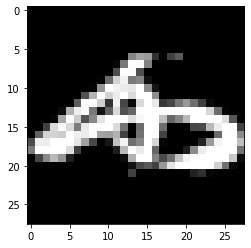

In [40]:
# pick a sample to plot
sample = 1
image = train_data[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

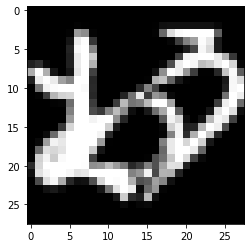

In [41]:
# pick a sample to plot
sample = 2
image = train_data[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

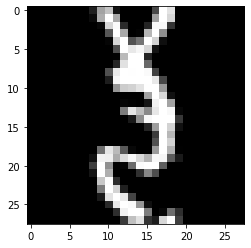

In [42]:
# pick a sample to plot
sample = 3
image = train_data[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [45]:
train_labels

array([8, 7, 0, ..., 0, 4, 9], dtype=uint8)

In [46]:
num = 10
images = train_data[:num]
labels = train_labels[:num]

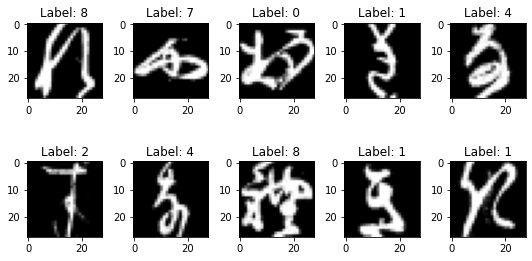

In [47]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [50]:
num = 10
images = train_data[:num]
labels = train_labels[:num]

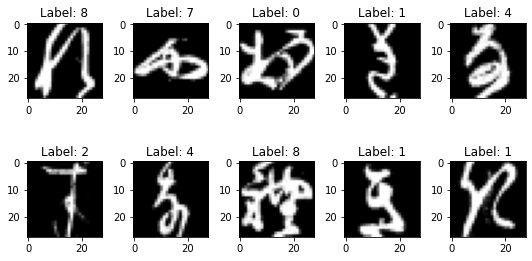

In [51]:
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()